# Betting markets - chart individual seat probabilities

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Plot-seats" data-toc-modified-id="Plot-seats-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot seats</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plot</a></span></li><li><span><a href="#Seats-that-look-like-a-close-contest" data-toc-modified-id="Seats-that-look-like-a-close-contest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Seats that look like a close contest</a></span></li><li><span><a href="#Seats-where-Greens-most-competitve" data-toc-modified-id="Seats-where-Greens-most-competitve-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Seats where Greens most competitve</a></span></li><li><span><a href="#Seats-where-others-are-most-competitive" data-toc-modified-id="Seats-where-others-are-most-competitive-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Seats where others are most competitive</a></span></li></ul></li></ul></div>

## Python set-up

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

import common

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter
plt.style.use('./markgraph.mplstyle')

/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Get data

In [2]:
FILE = '../historical-data/sportsbet-2022-individual-seats.csv'
df = pd.read_csv(FILE, na_values = 'SUS', parse_dates=['datetime'])
df = df[df['value'].notna()] # ignore missing values
len(df)

2766

In [3]:
df.columns

Index(['datetime', 'seat', 'variable', 'value'], dtype='object')

## Plot seats

In [13]:
def colourise(s:str) -> str:
    colors = {
        'coalition': 'royalblue',
        'labor':     '#cc0000',
        'green':     'darkgreen',
        'independent': 'darkorange',
    }
    for party in colors.keys():
        if party in s.lower():
            return colors[party]
    return 'hotpink'

def plot_seat(df:pd.DataFrame, seat:str) -> float:

    # get seat probabilities
    IGNORE_ABOVE = 25 # dollars - minimise impact of the longshot bias
    seat_probs = (
        df[df.seat == seat]
        .pivot(index='datetime', columns='variable', values='value')
        .sort_index(ascending=True)
        .pipe(lambda x: x.where(x <= IGNORE_ABOVE, other=np.nan))
        .dropna(how='all', axis=1)
        .pipe(lambda x: 1 / x)
        .pipe(lambda x: x.div(other=x.sum(axis=1), axis=0))
    ) * 100 # per cent
    
    # capture some additional statistics
    latest = seat_probs.iloc[-1]
    latest_best = latest.max()
    green_prob = None if 'Green' not in latest.index else latest['Green']
    majors = ['Coalition', 'Liberal', 'Labor', 'Green']
    other_prob = latest[[x for x in latest.index if x not in majors]].sum()

    # plot
    markers = ['x', '+', 'D', 'o', 's', '^', 'v', ]
    fig, ax = plt.subplots()
    size = 9
    for i, column in enumerate(seat_probs.columns):
        c = colourise(column)
        m = markers[i]
        ax.plot(seat_probs.index, seat_probs[column], 
                markersize=size,
                lw=2, color=c, marker=m, label=column)
        size -= 1
    ax.axhline(50, color='#999999', lw=0.5)
    ax.legend(loc='center left', prop={'size': 10})
    title = f'Sportsbet seat win probabilities over time - {seat}'
    common.plot_finalise(ax, title=title, ylabel='Implied Win Probability (%)')
    
    # return additional statistics
    return latest_best, green_prob, other_prob

### Plot

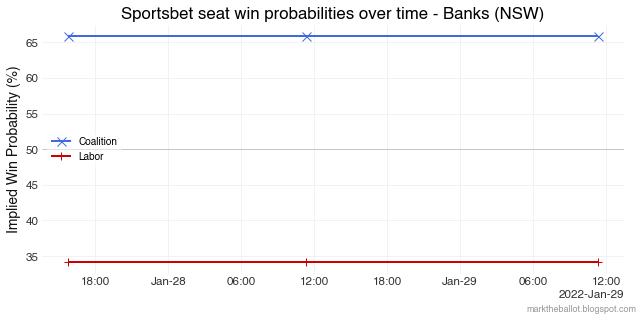

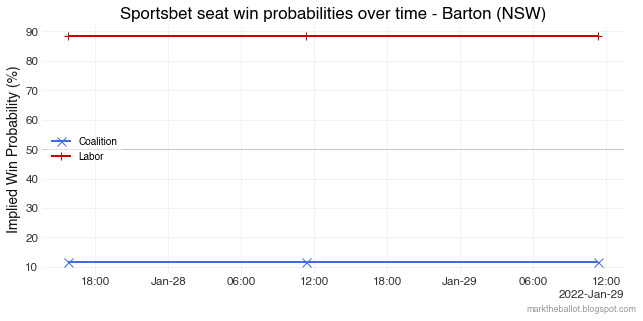

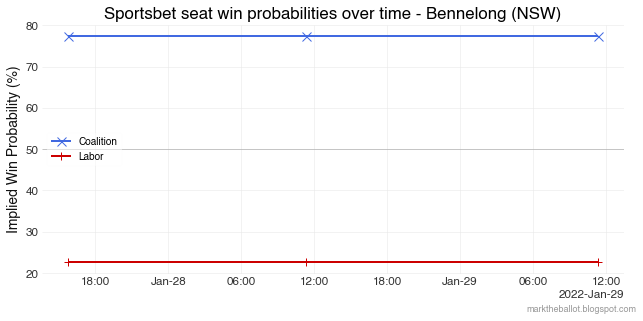

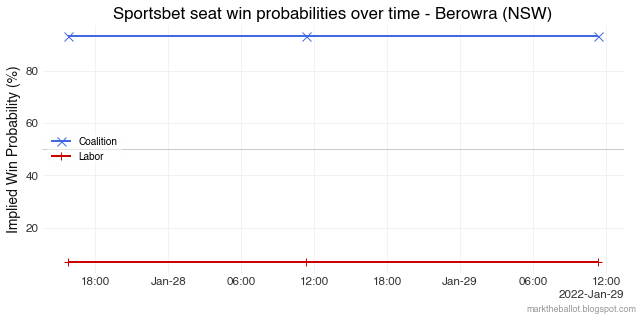

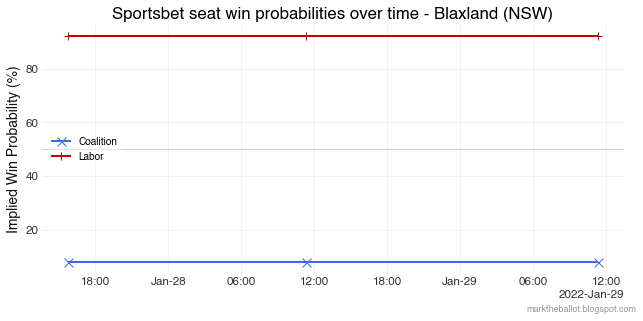

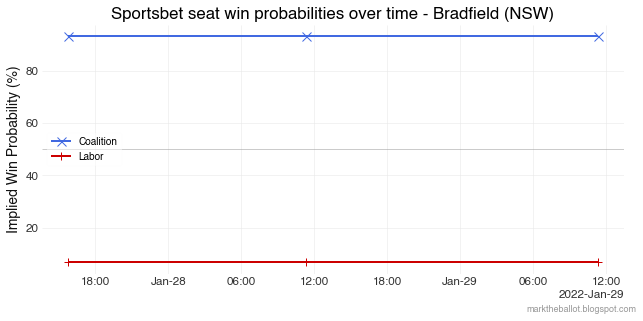

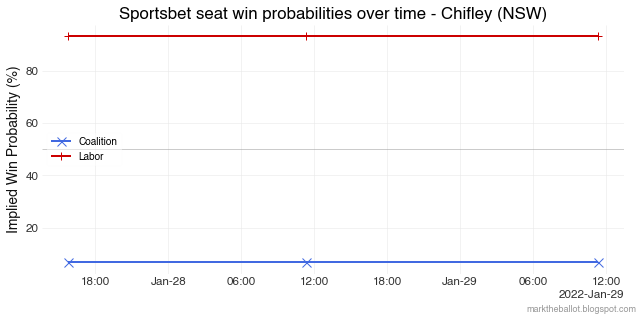

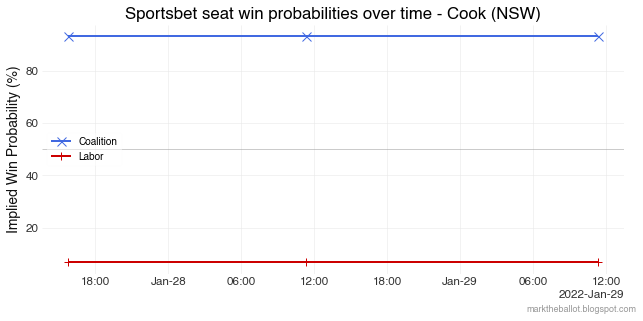

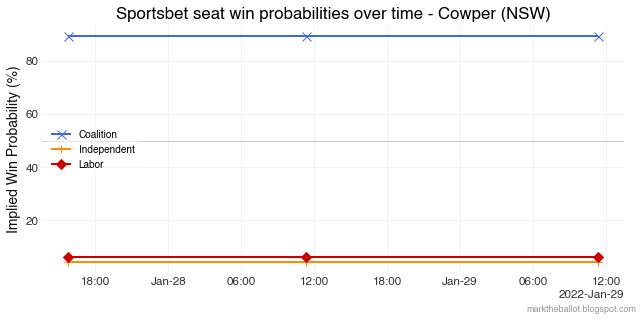

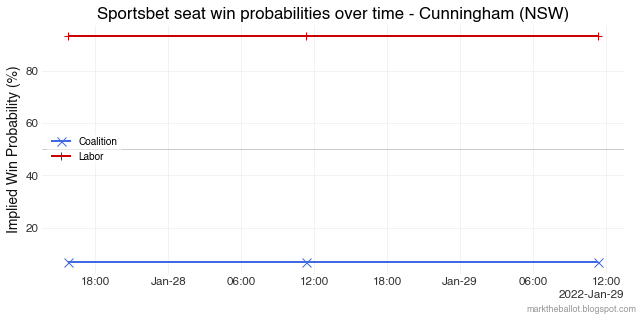

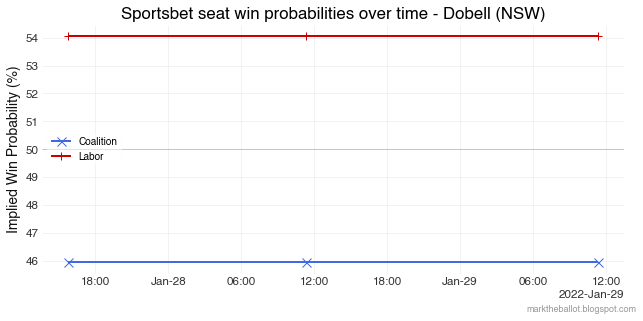

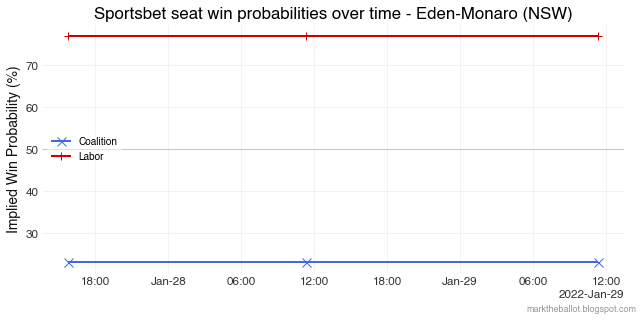

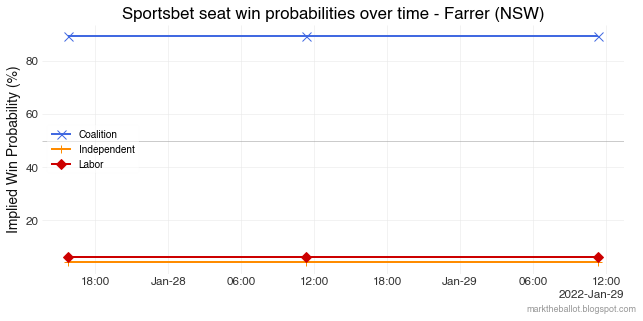

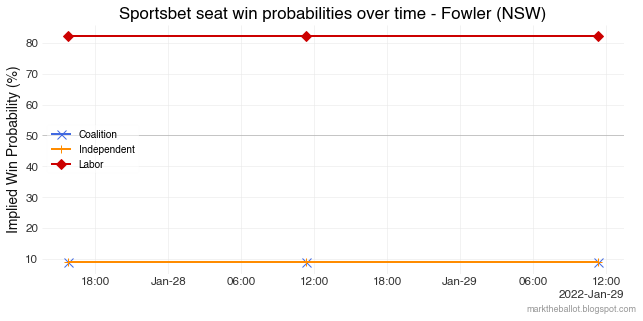

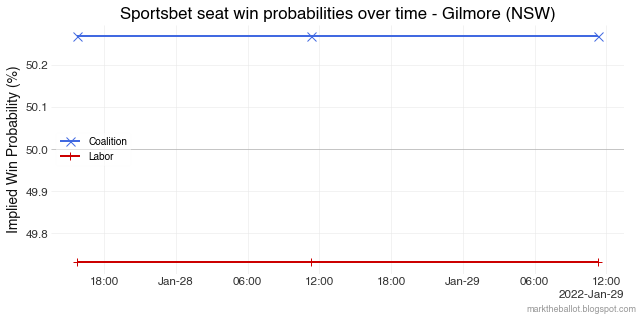

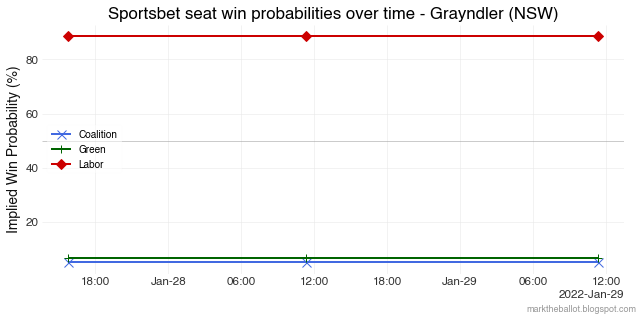

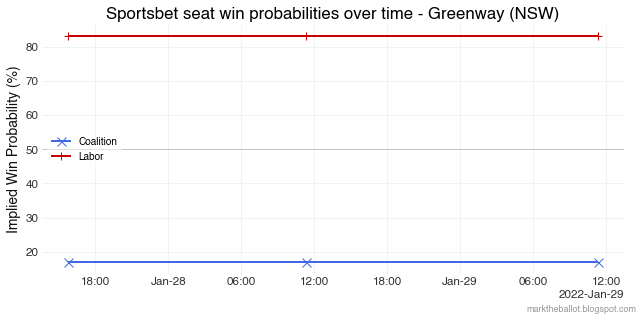

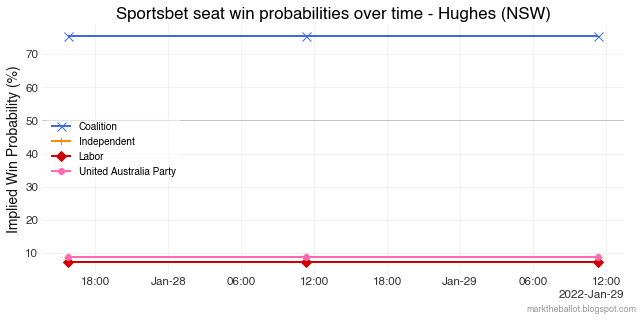

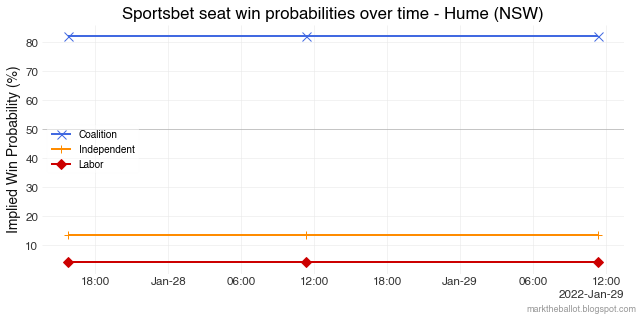

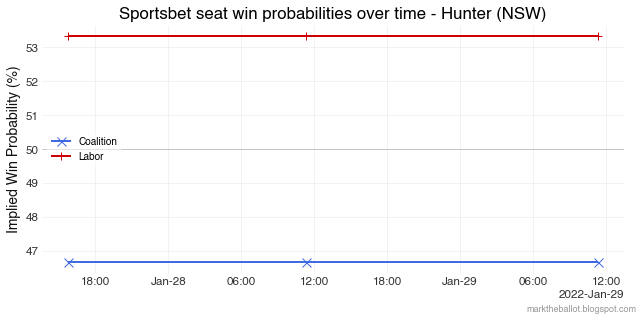

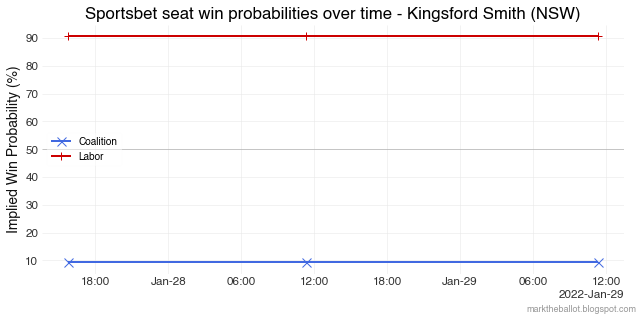

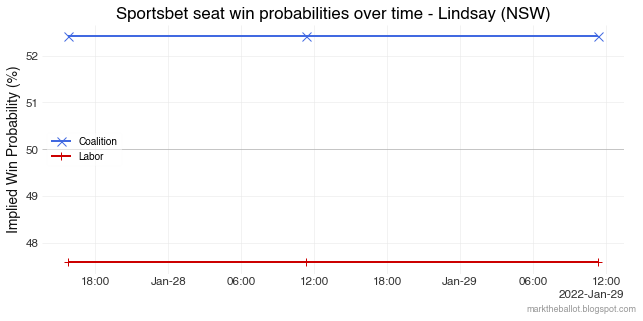

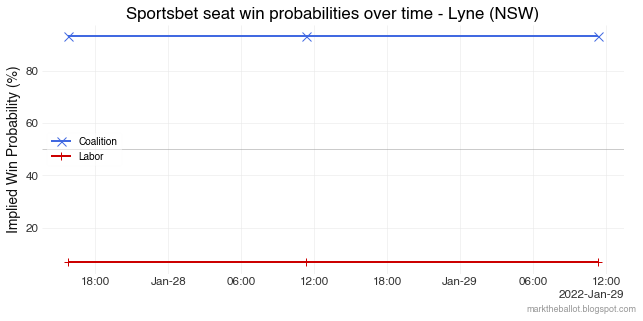

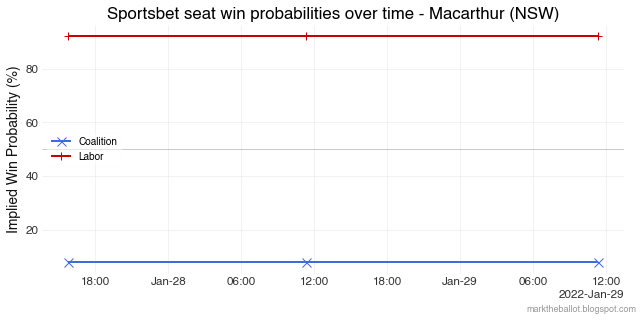

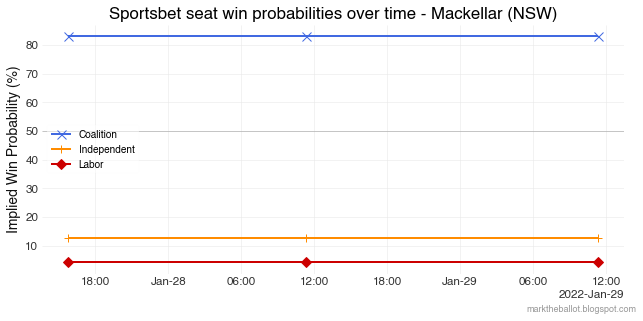

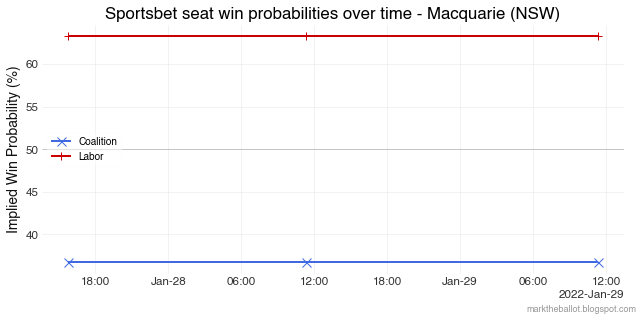

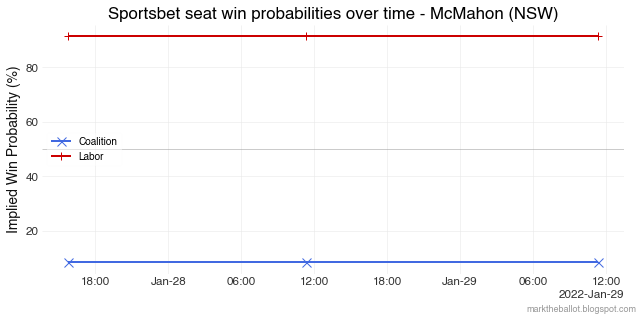

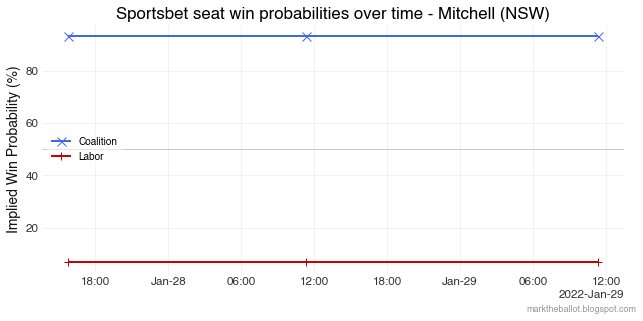

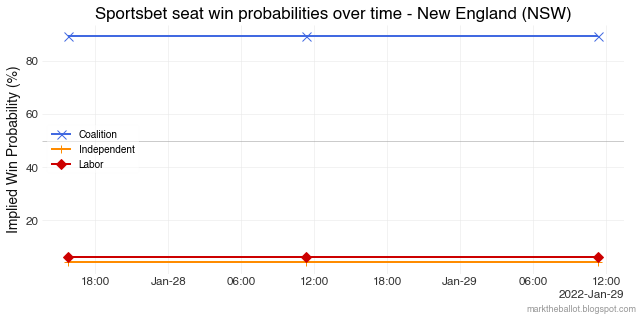

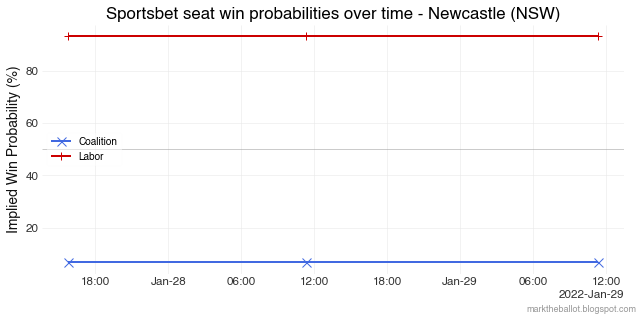

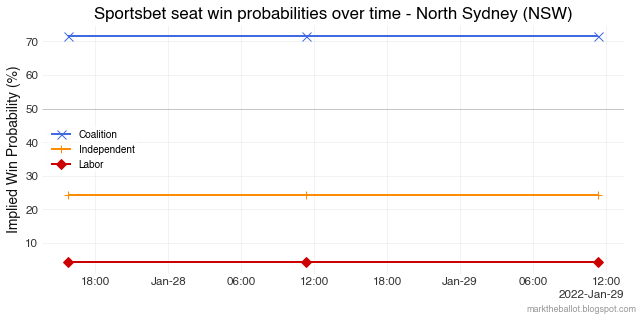

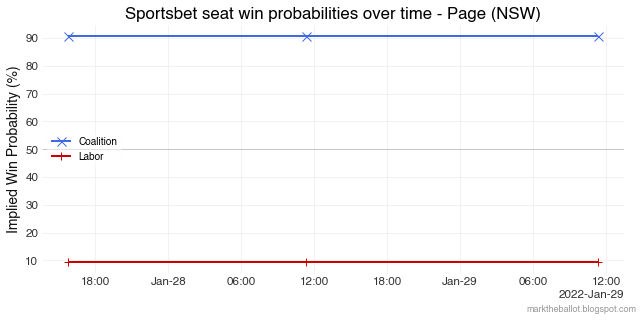

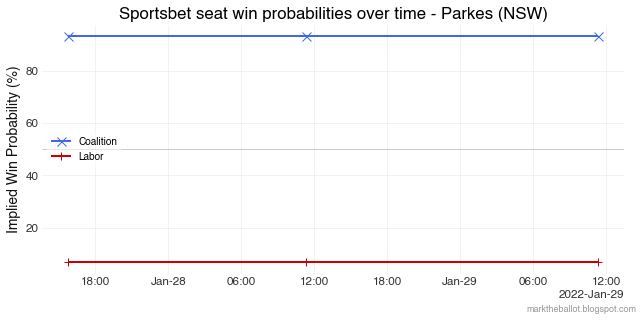

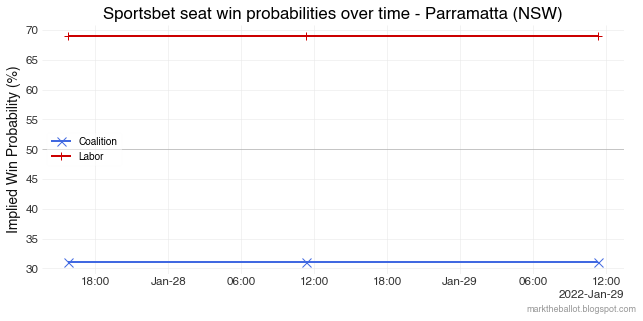

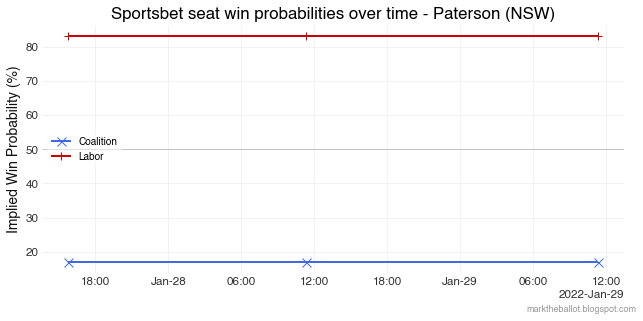

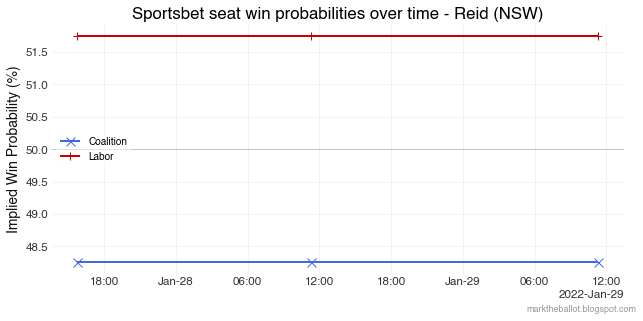

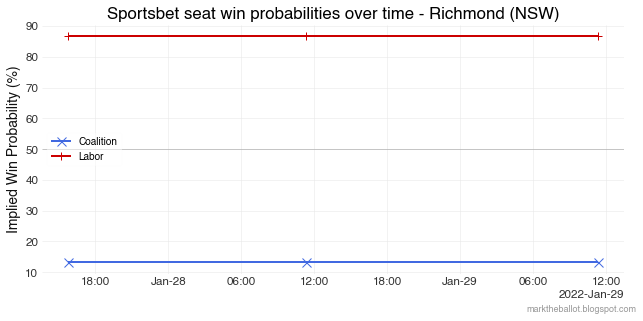

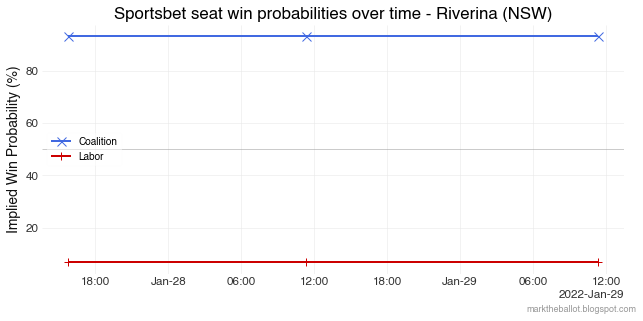

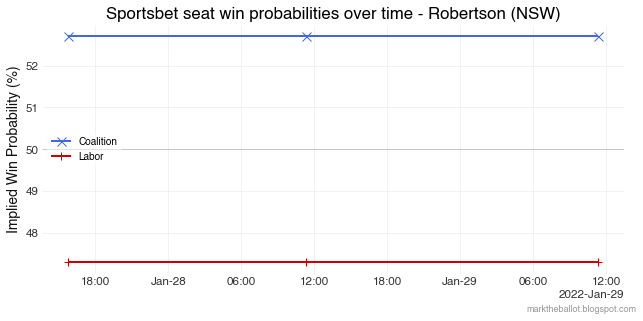

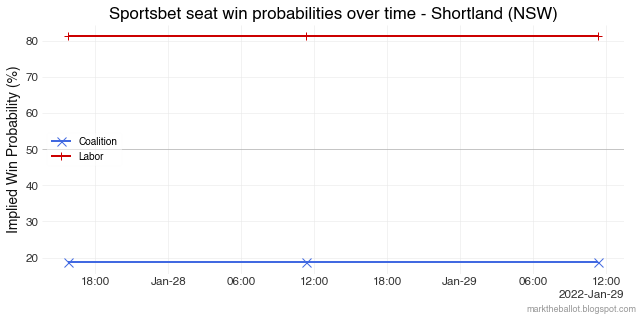

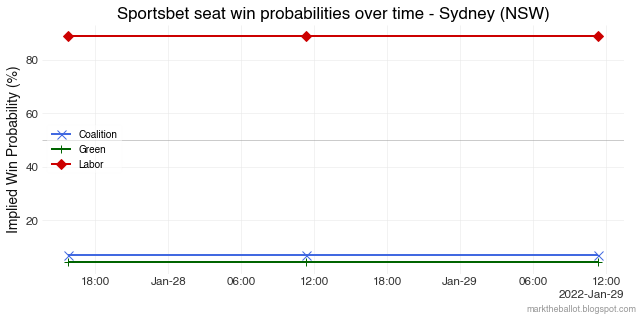

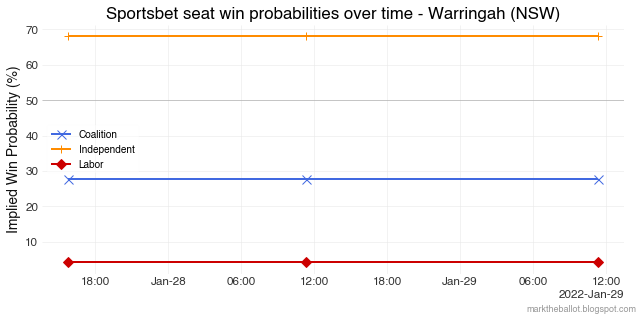

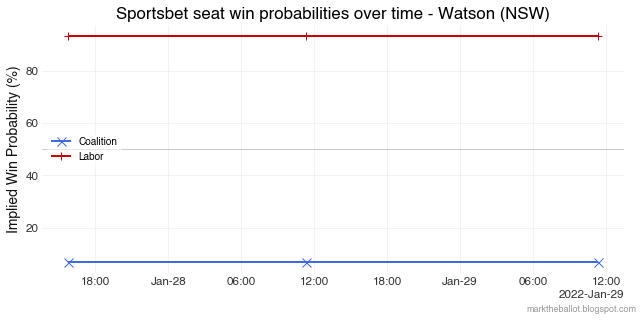

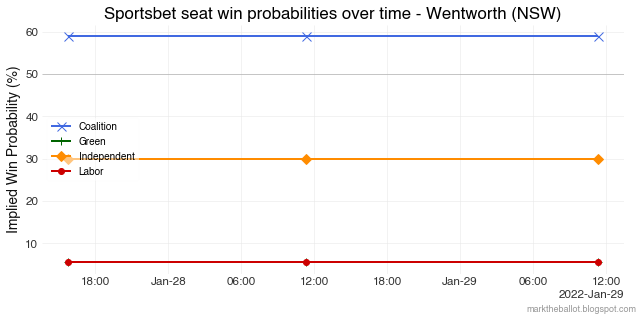

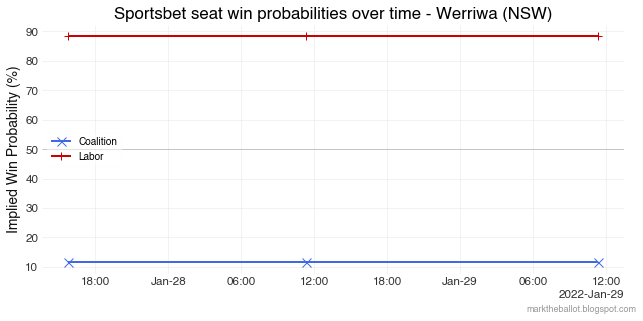

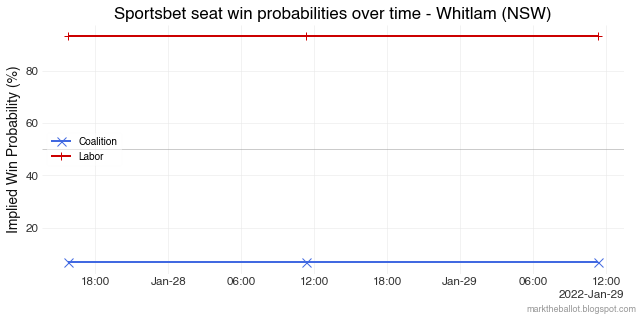

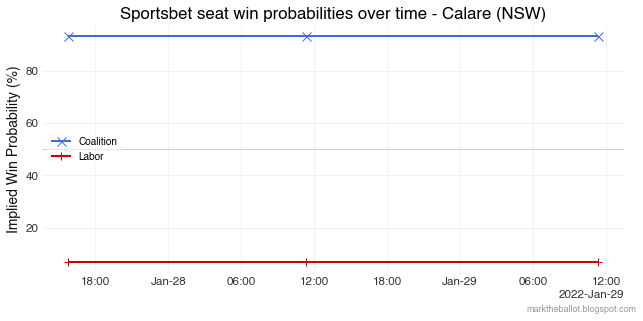

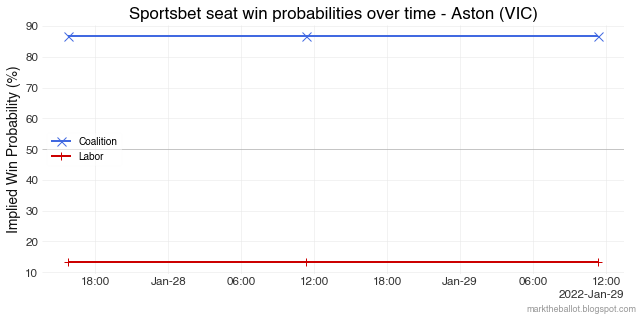

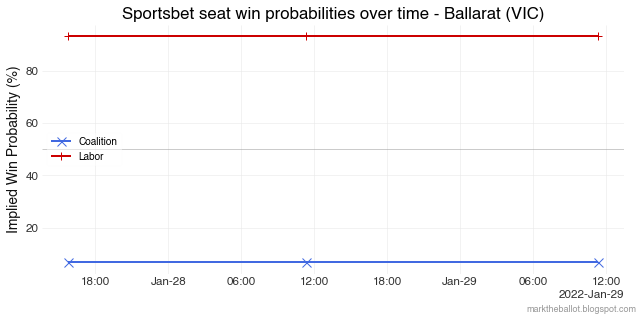

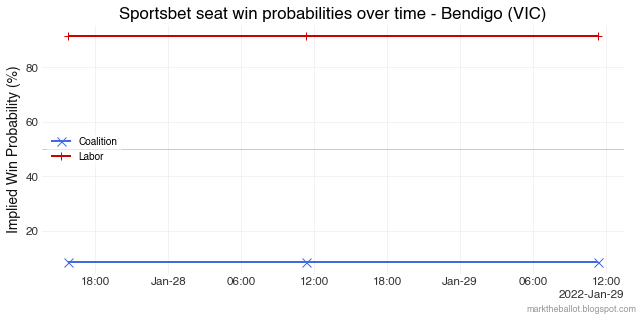

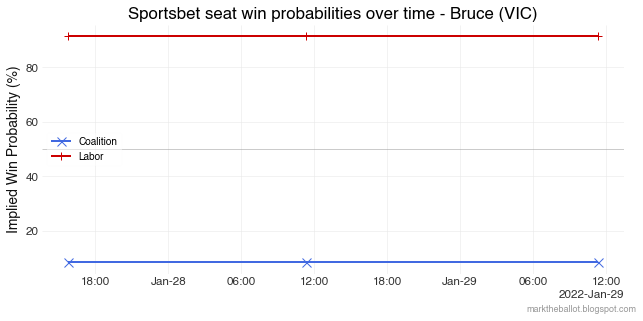

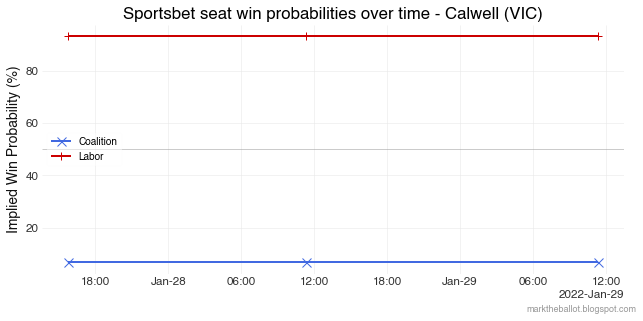

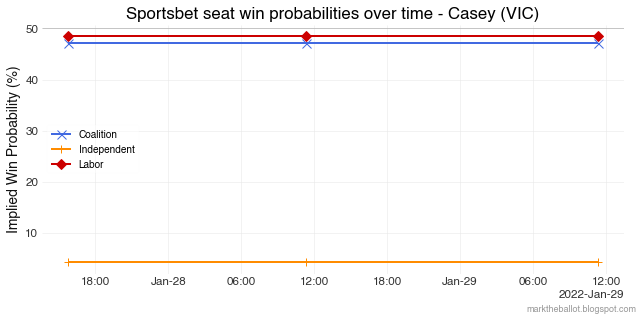

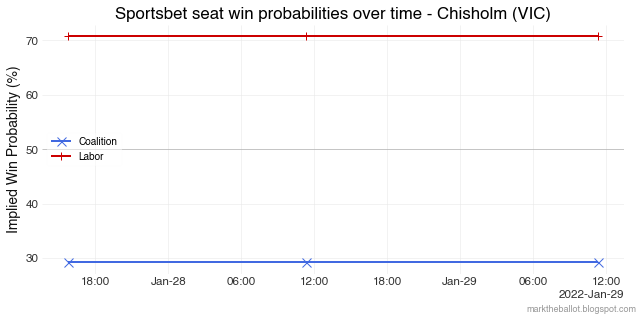

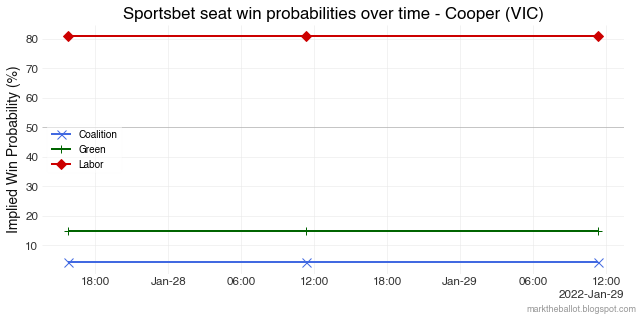

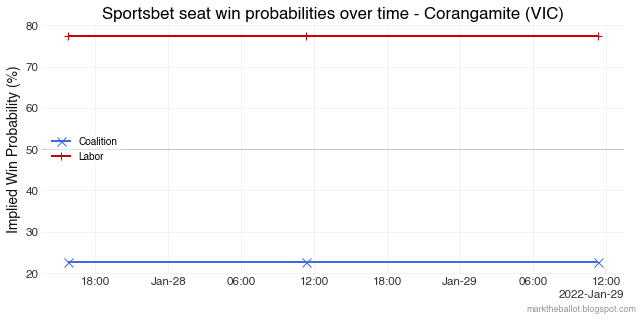

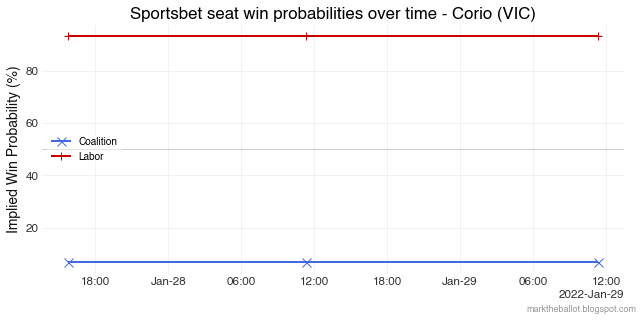

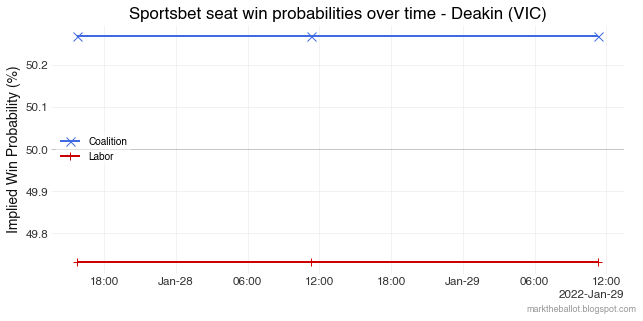

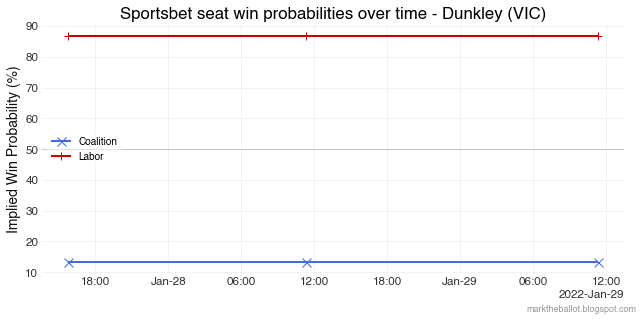

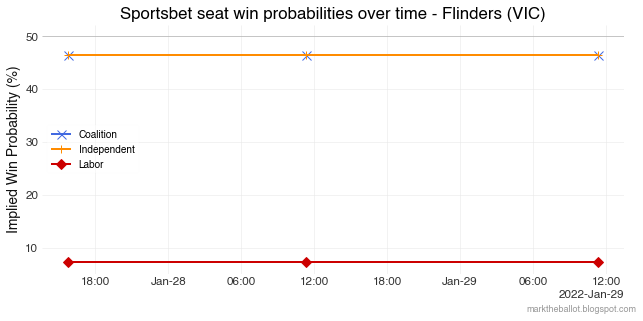

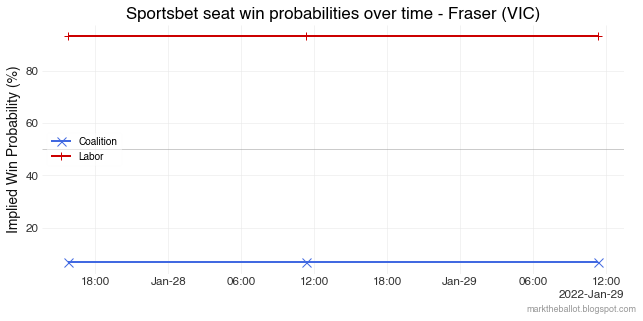

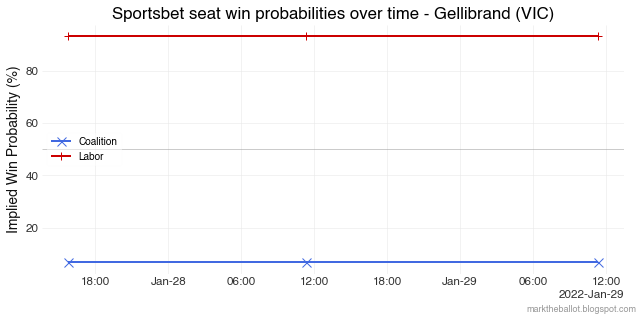

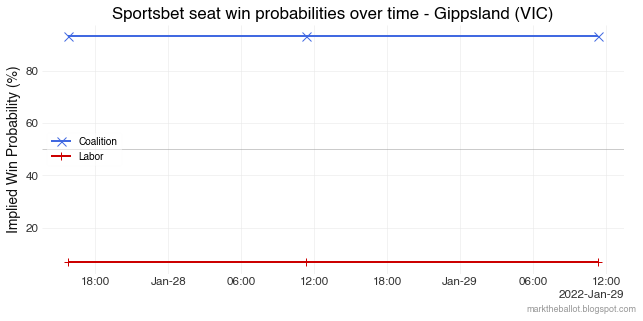

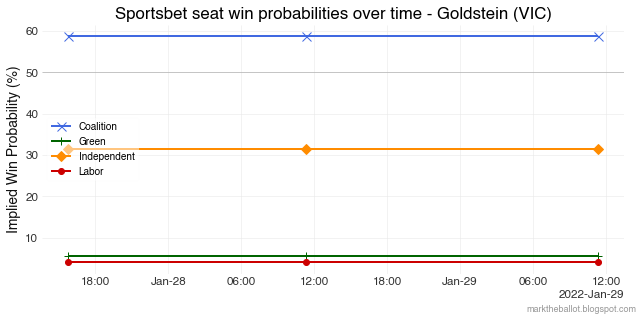

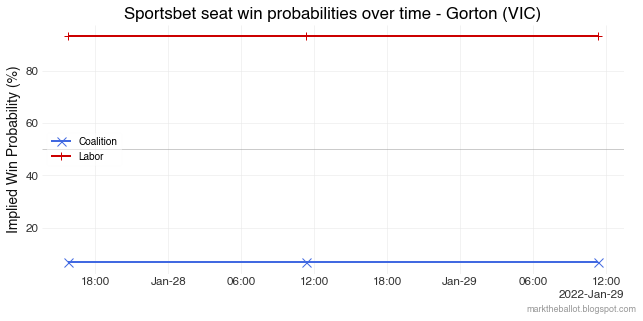

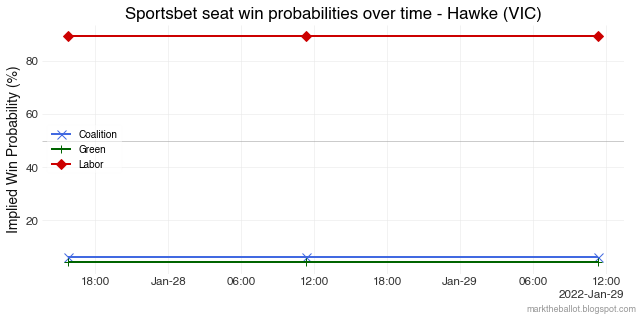

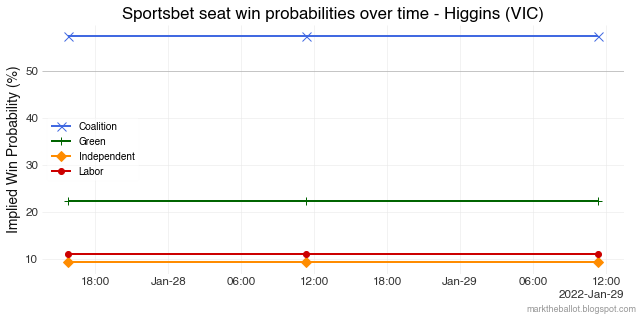

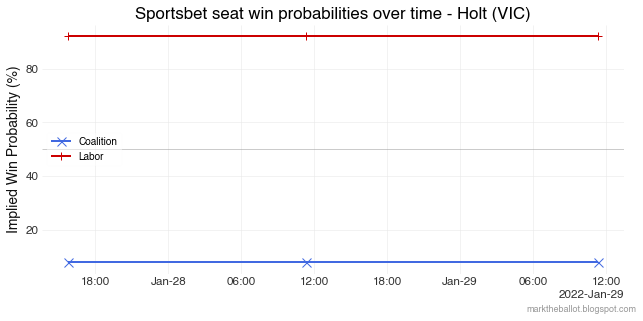

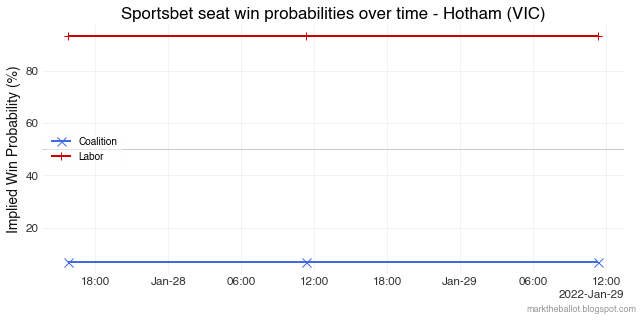

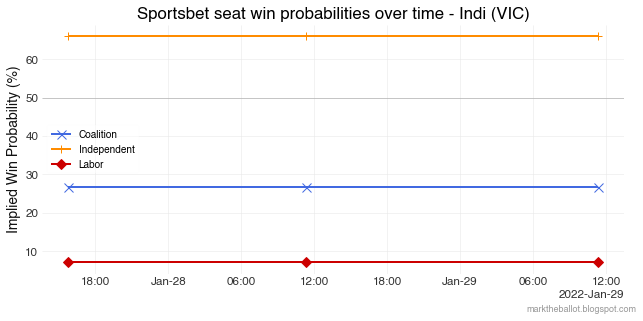

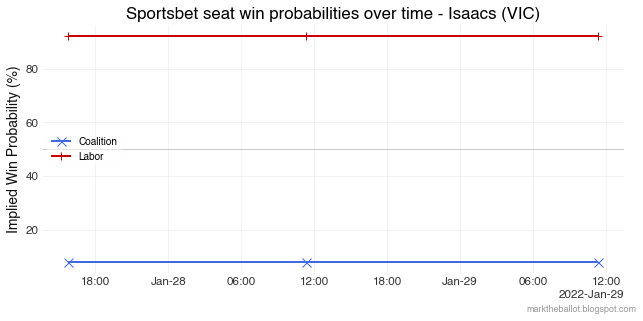

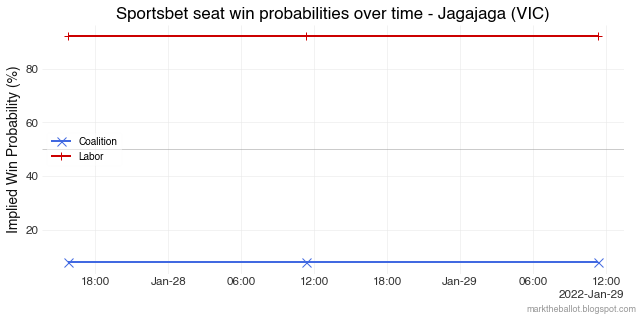

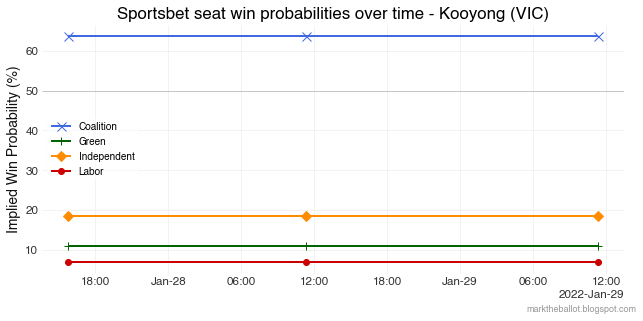

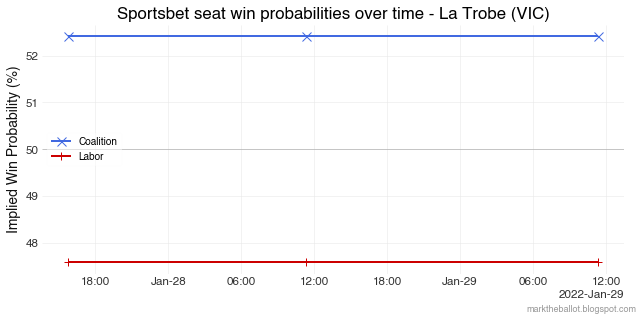

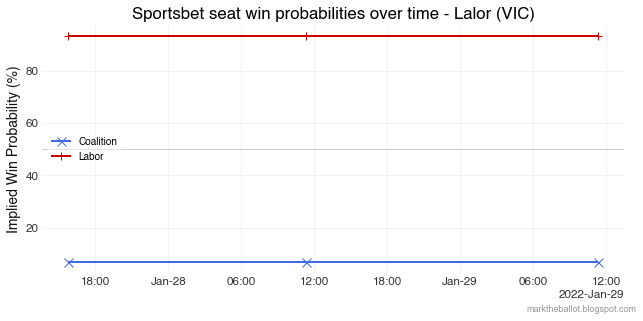

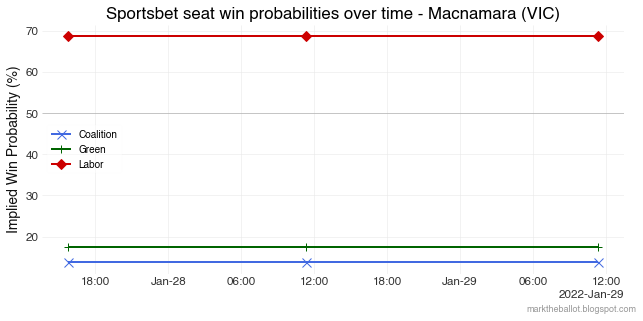

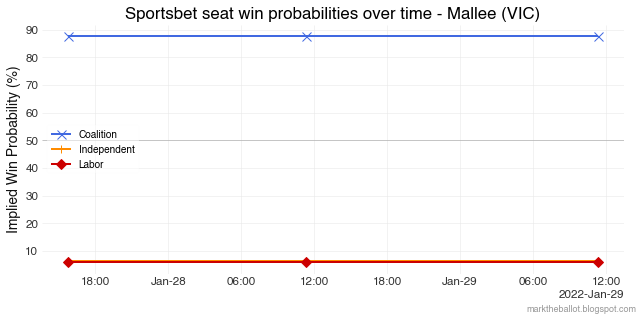

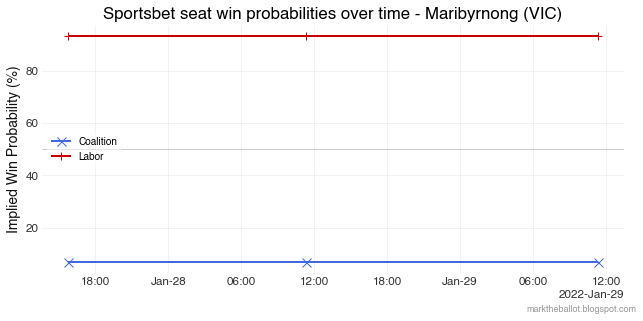

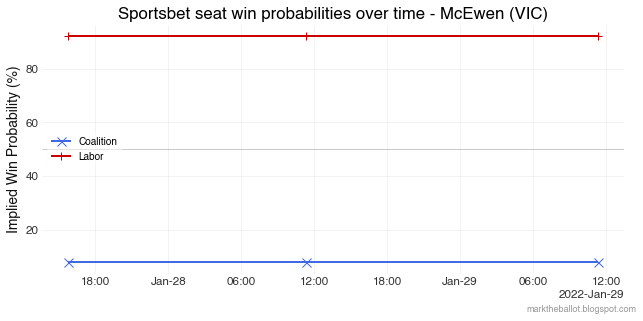

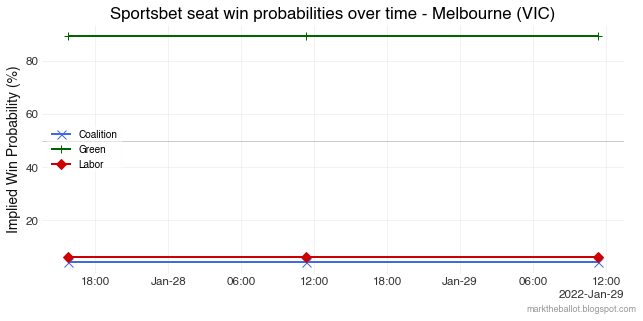

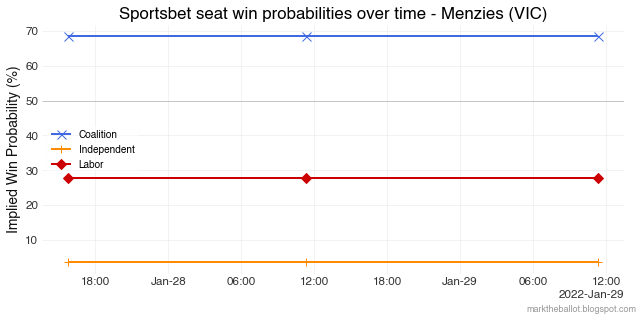

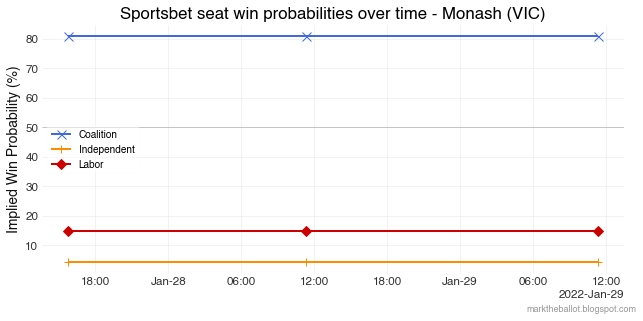

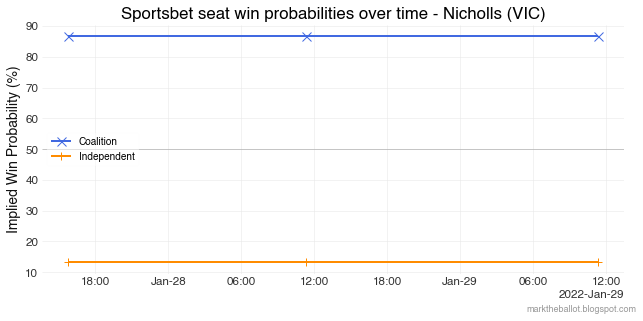

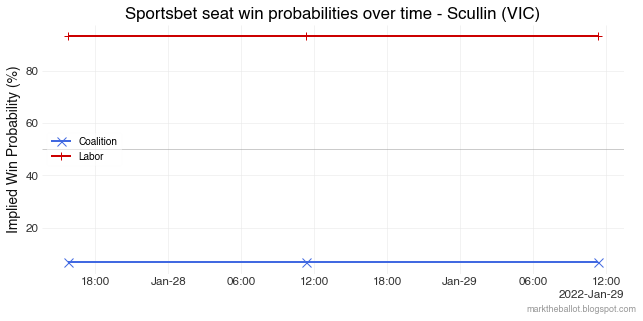

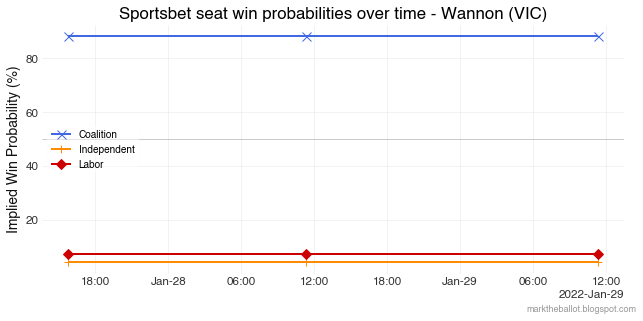

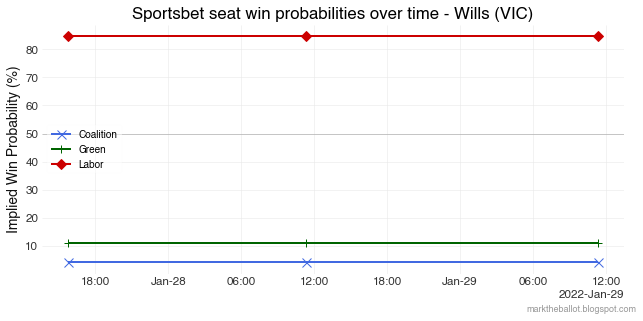

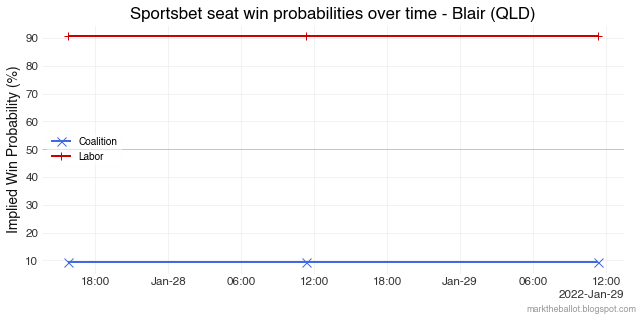

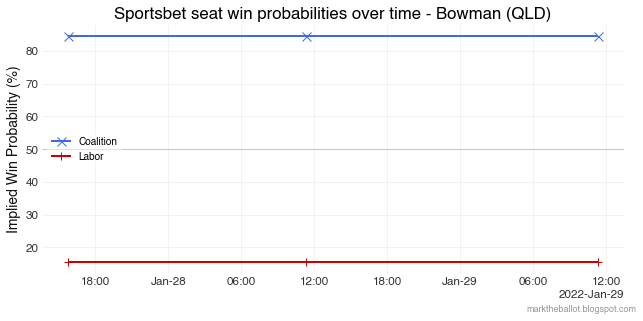

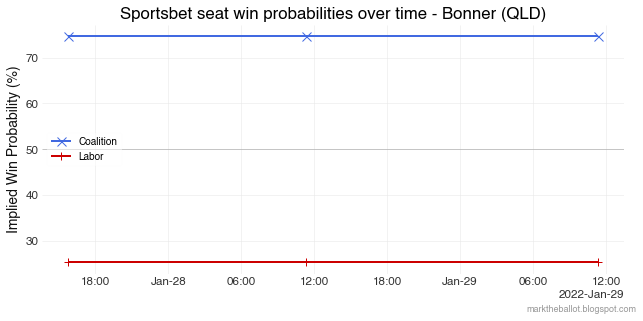

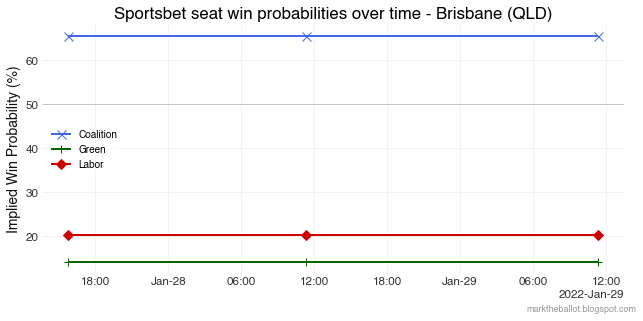

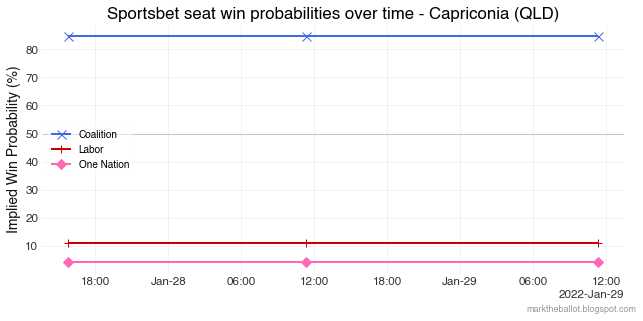

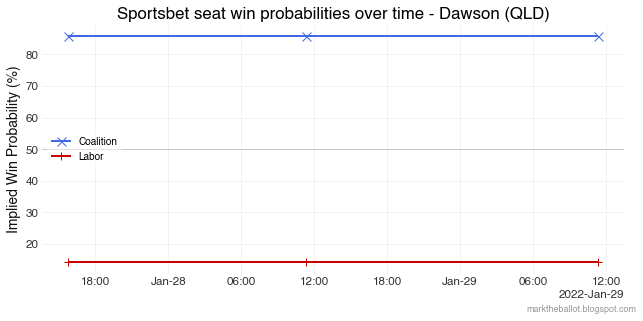

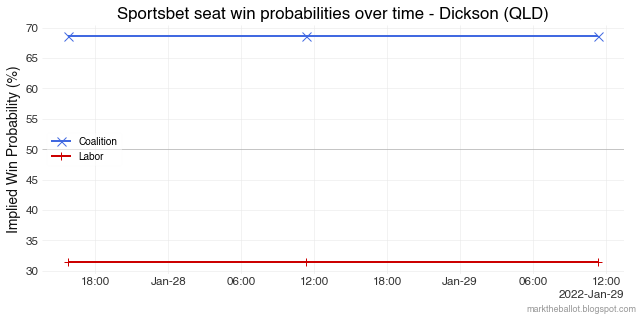

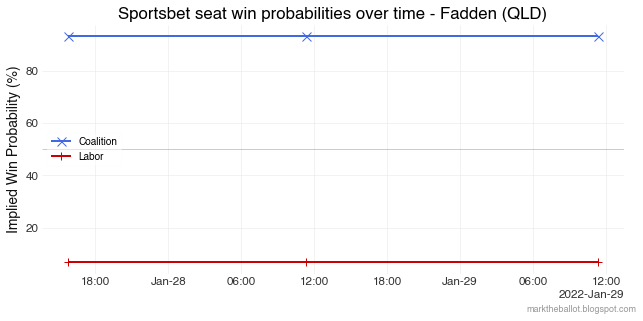

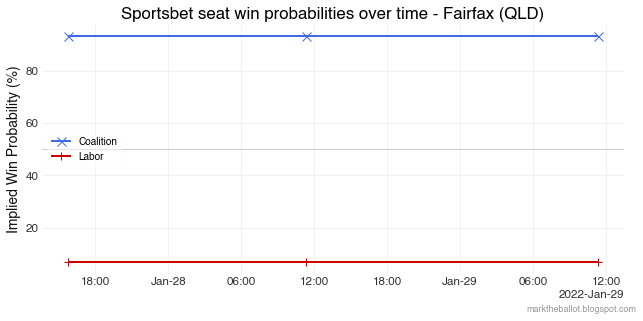

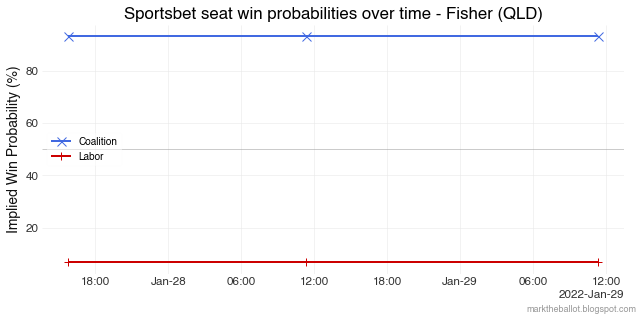

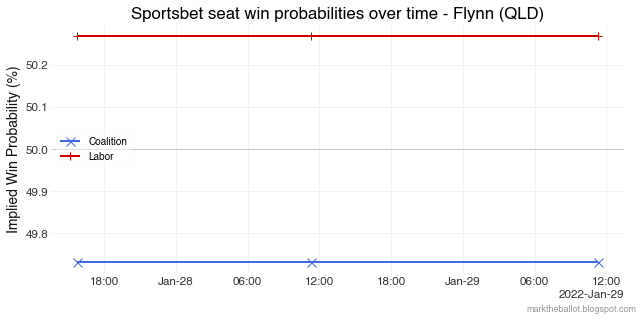

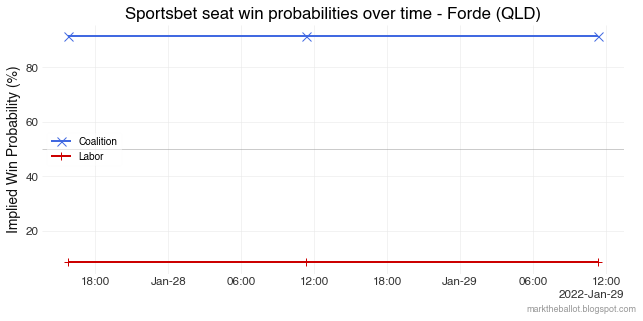

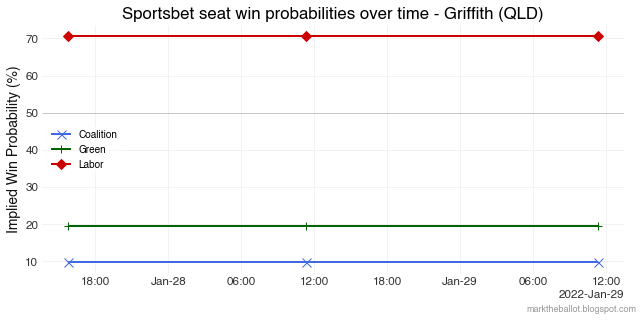

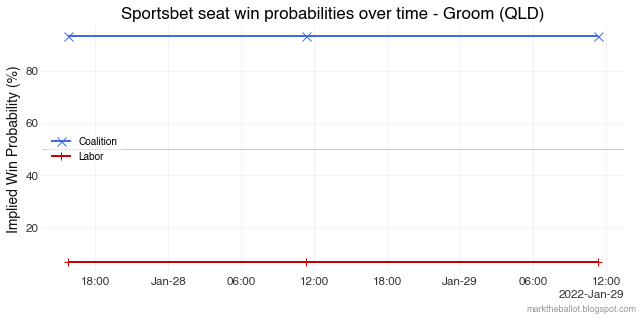

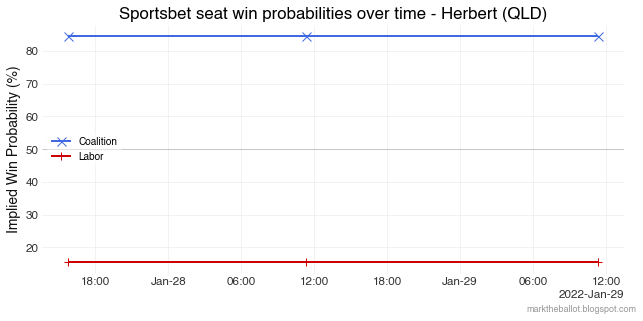

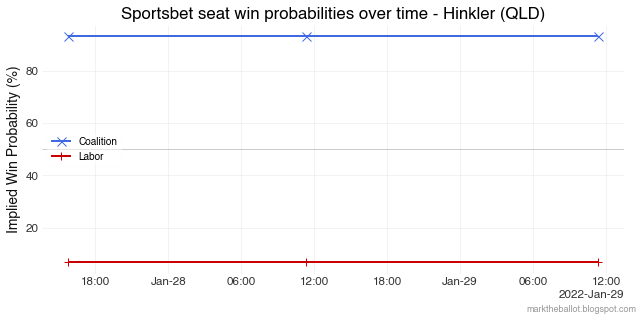

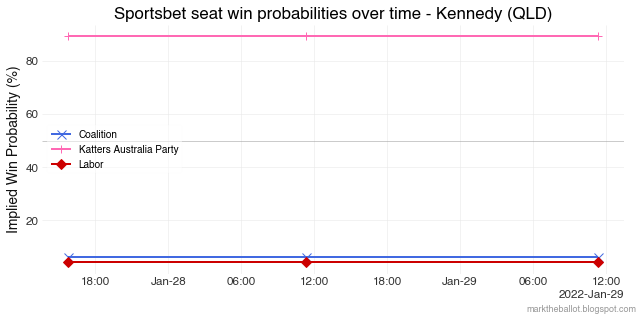

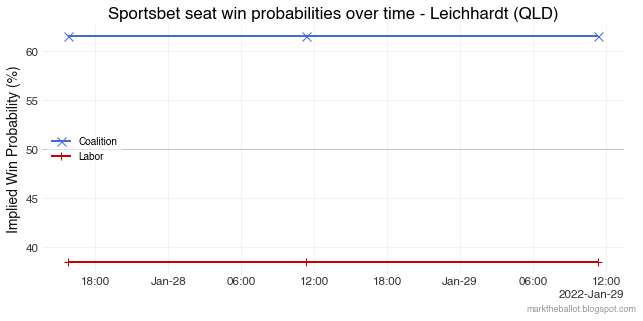

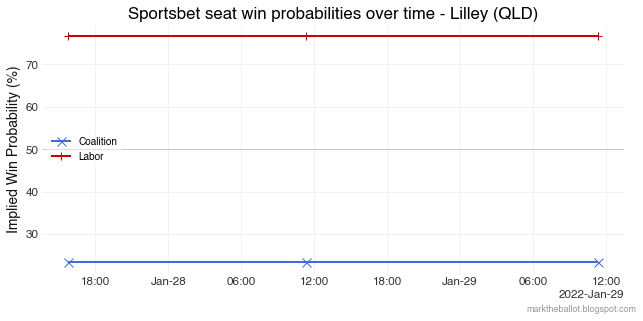

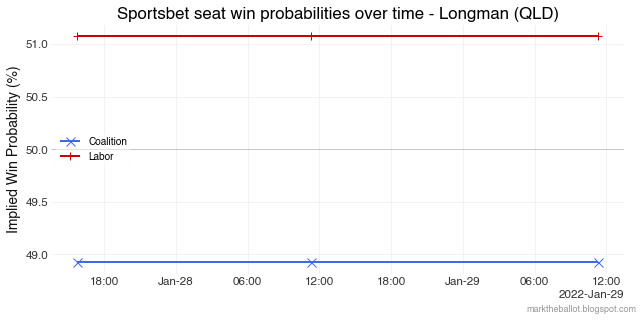

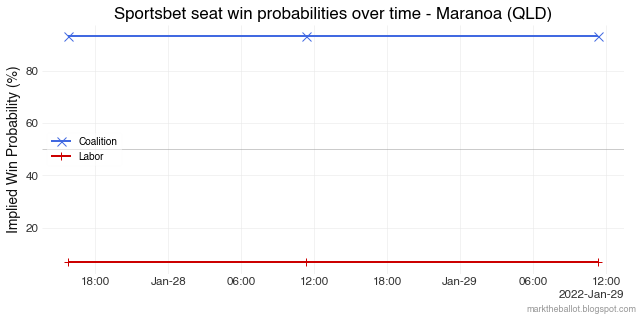

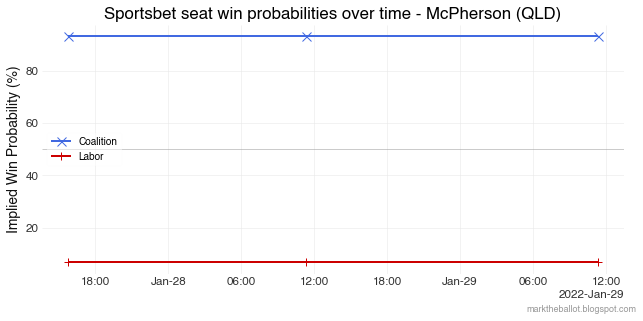

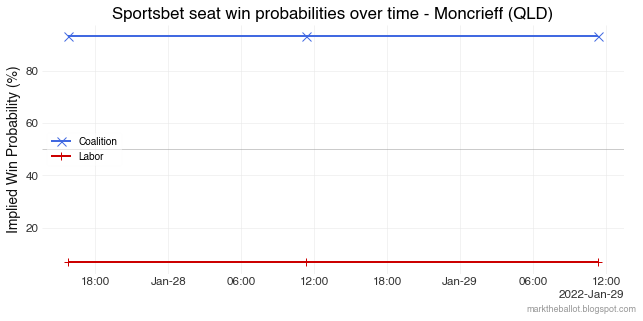

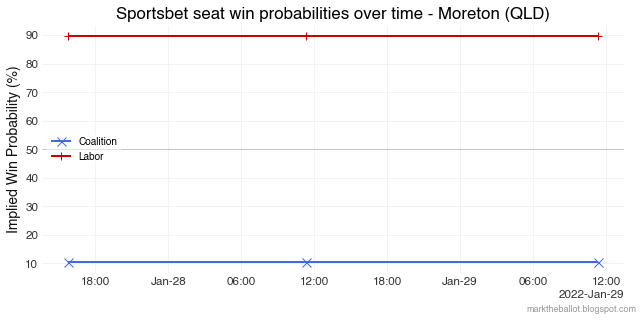

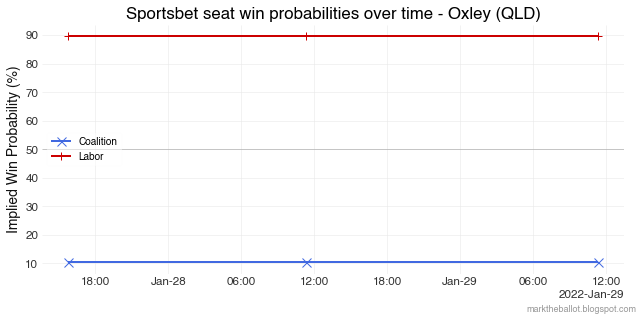

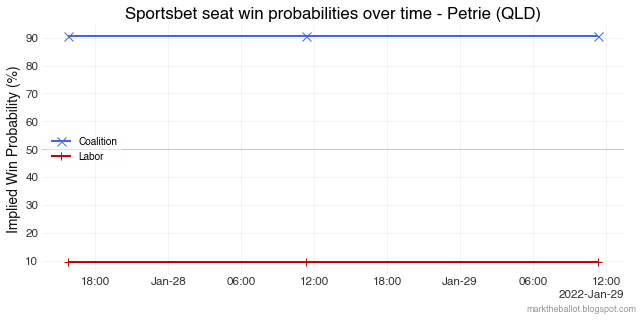

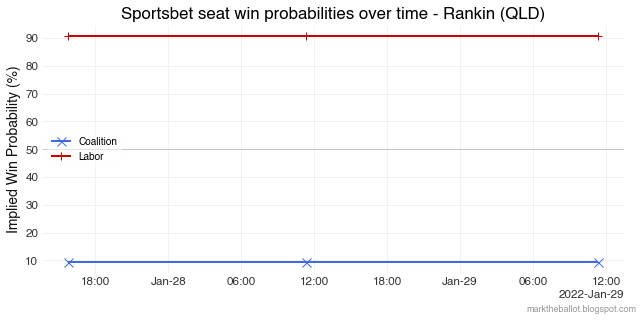

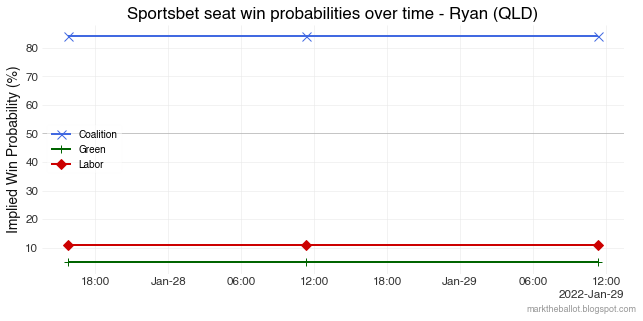

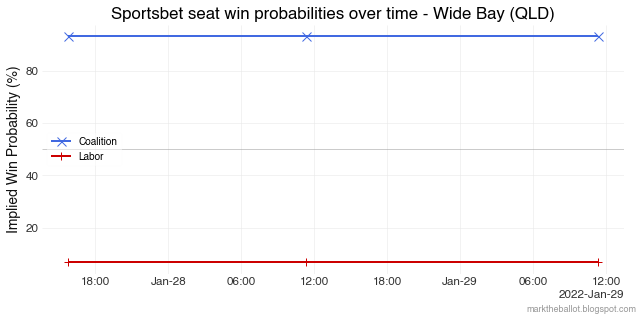

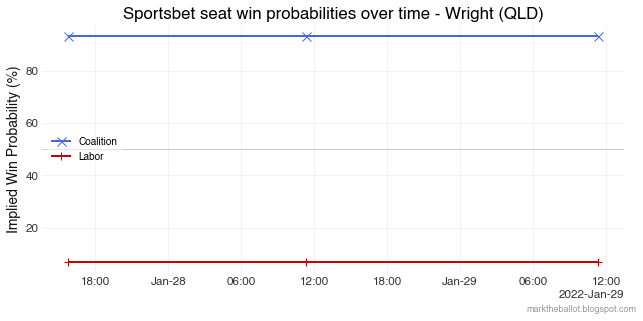

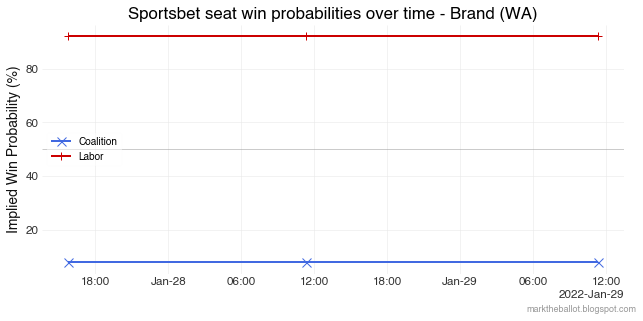

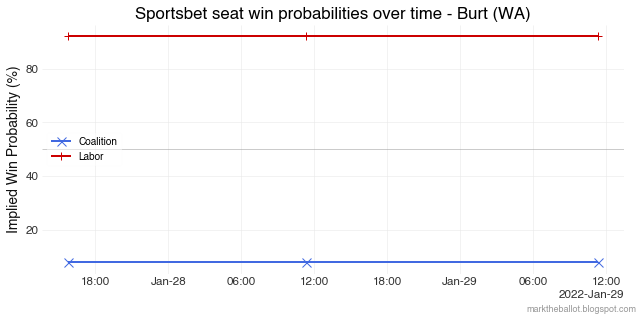

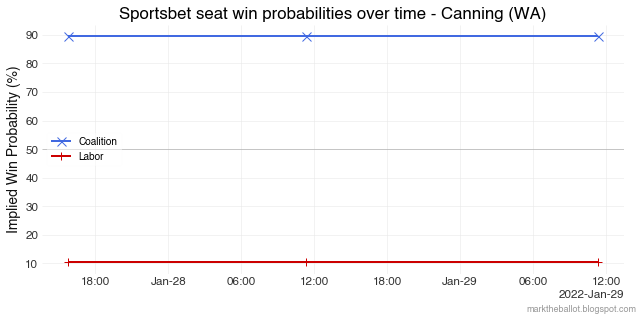

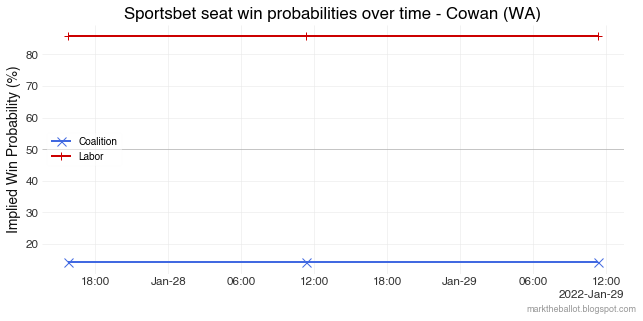

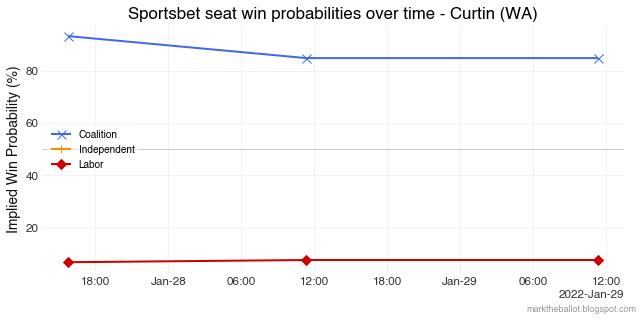

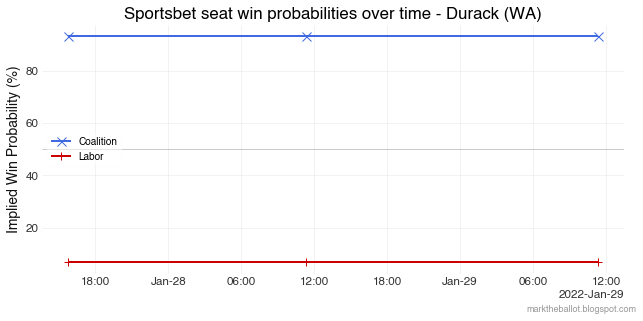

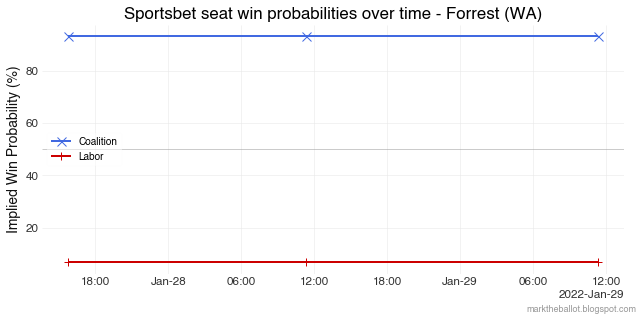

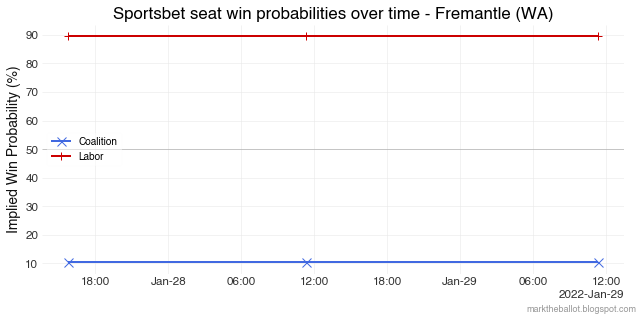

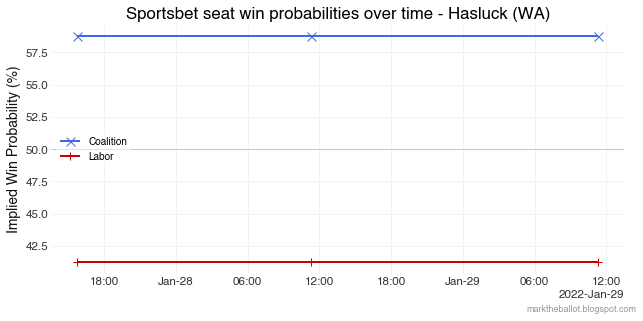

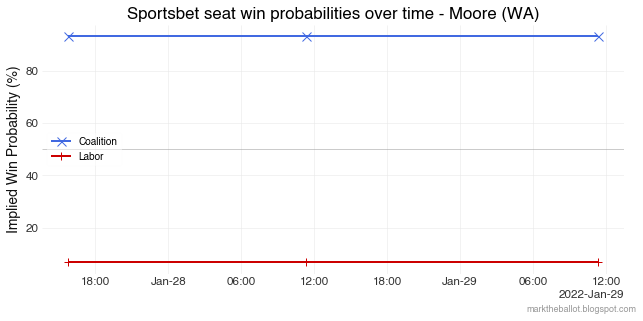

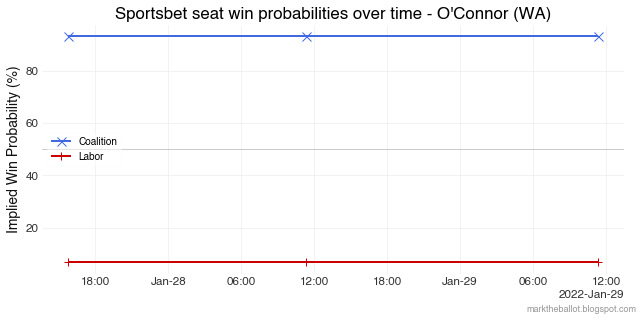

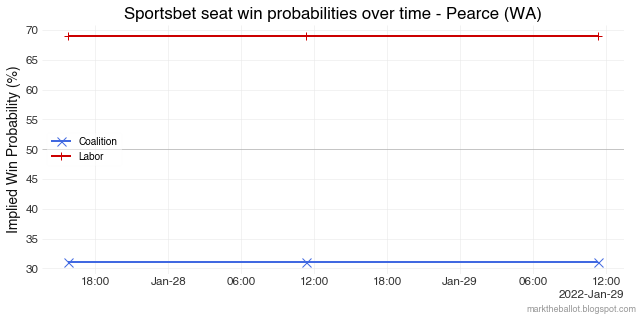

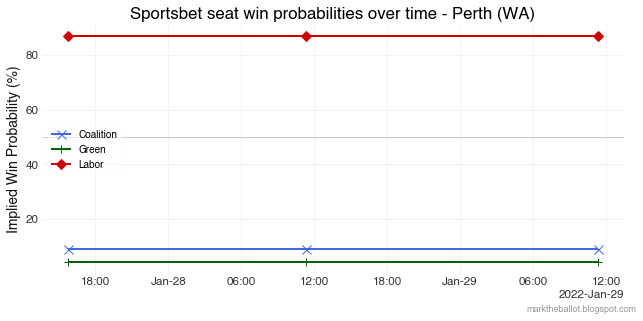

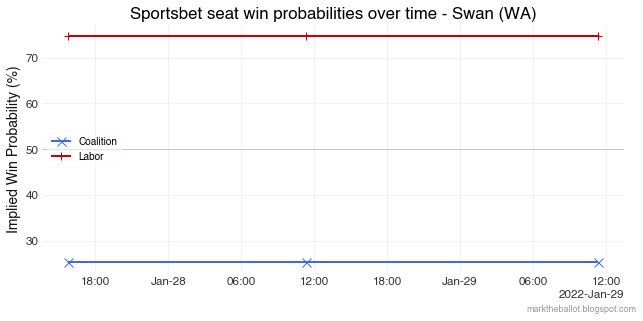

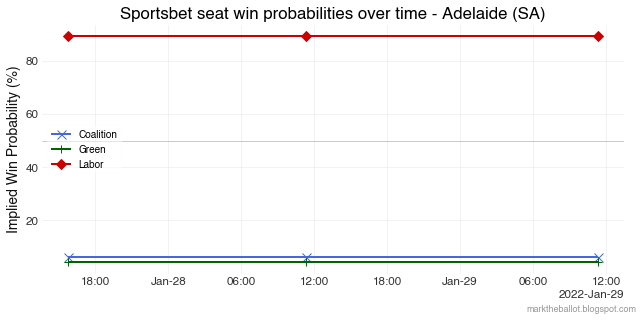

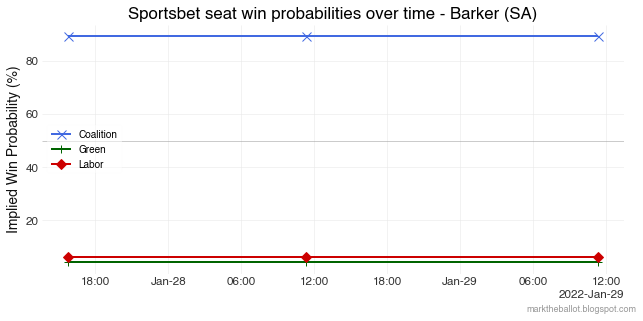

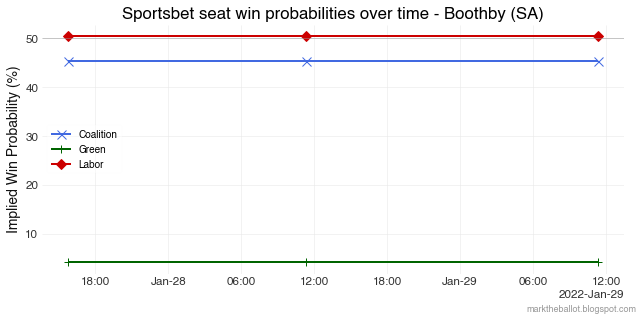

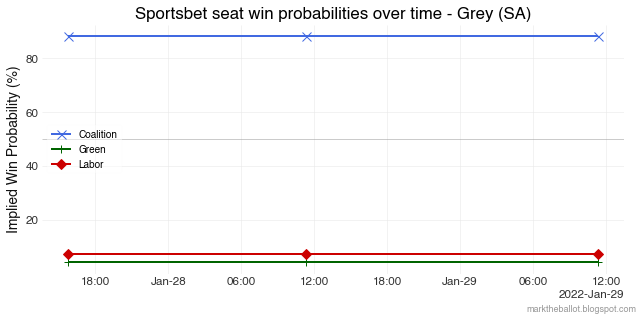

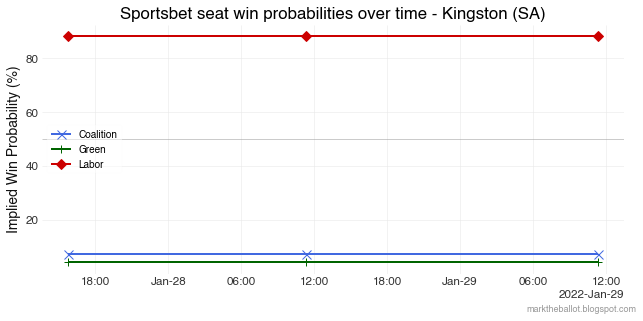

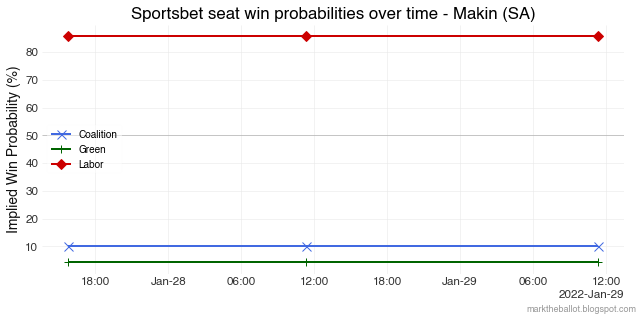

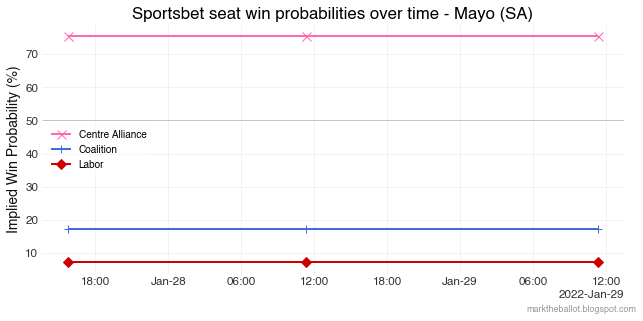

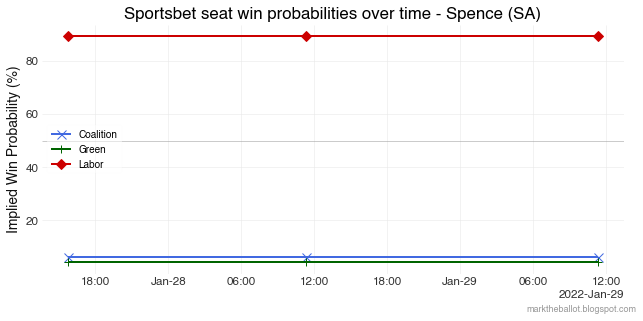

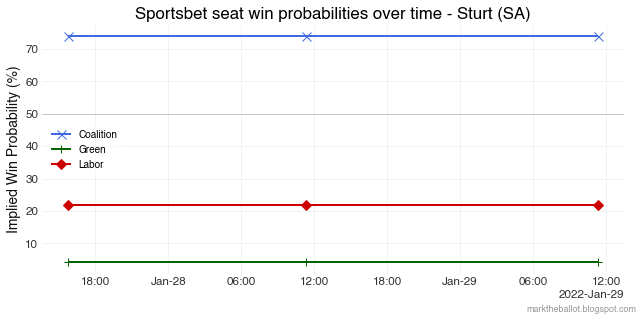

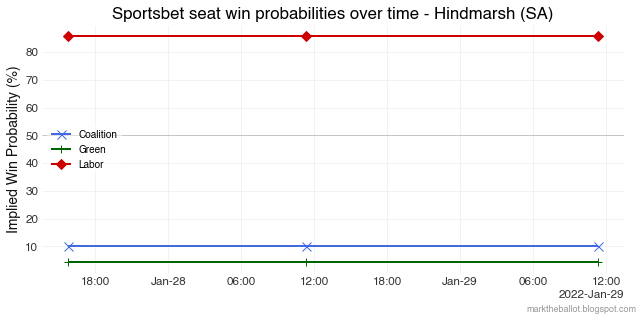

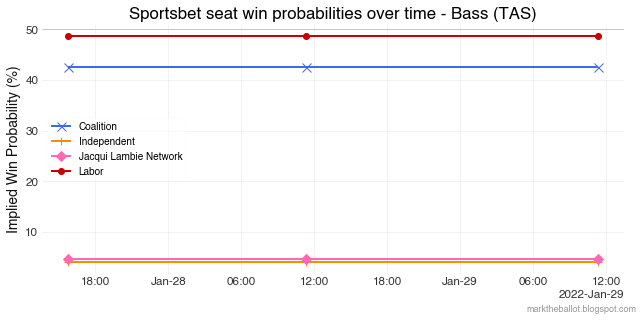

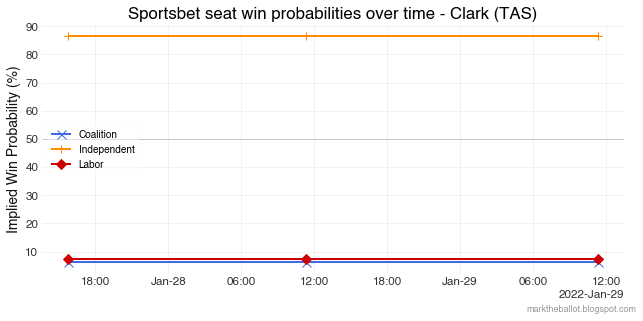

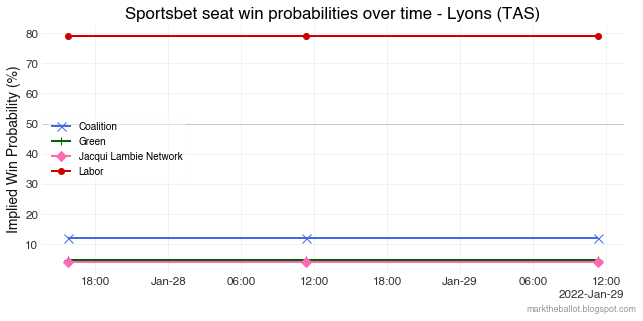

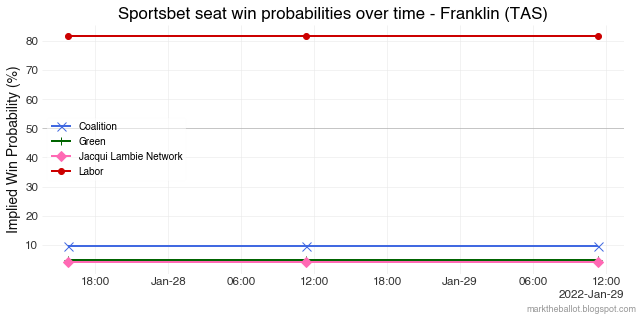

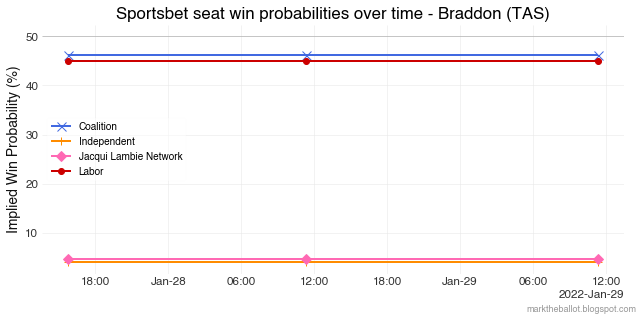

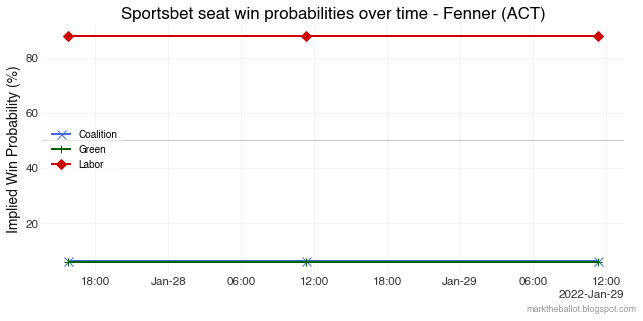

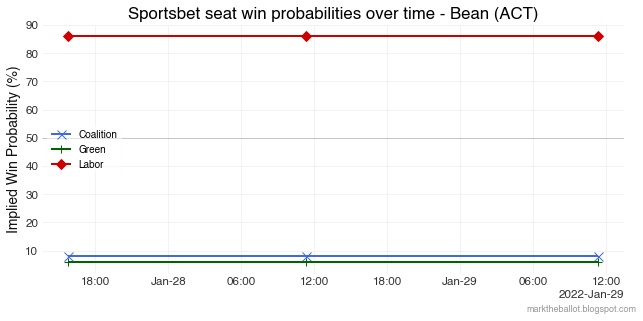

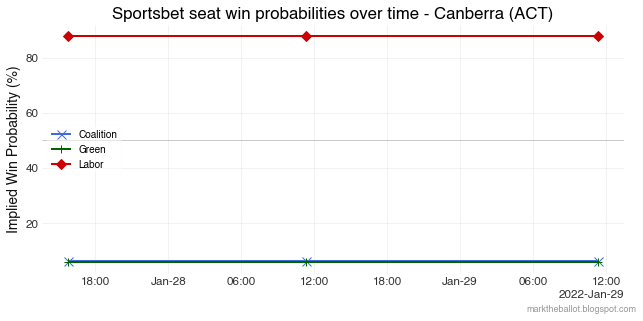

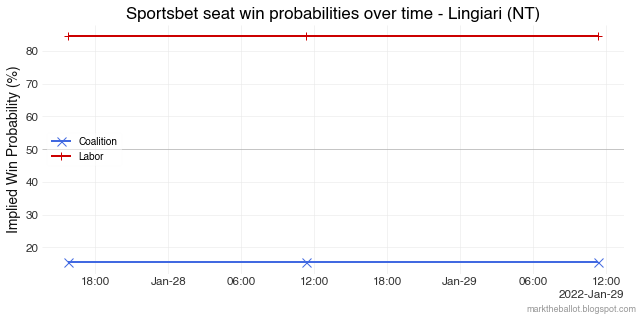

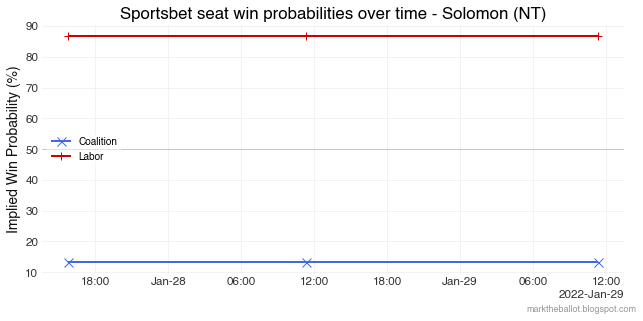

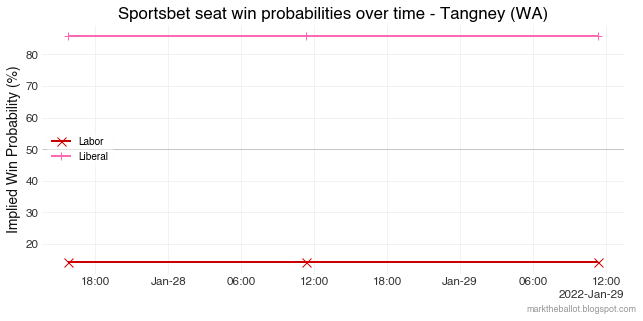

In [14]:
# produce plots
best_dict = {}
green_dict = {}
other_dict = {}
for seat in df.seat.unique():
    best_dict[seat], green_dict[seat], other_dict[seat] = plot_seat(df, seat)

### Seats that look like a close contest

In [8]:
# identiy the close contest seats
best_series = pd.Series(best_dict).sort_values(ascending=True)
best_series[best_series <= 60]#.index

Braddon (TAS)      46.198825
Flinders (VIC)     46.385775
Casey (VIC)        48.501793
Bass (TAS)         48.648649
Deakin (VIC)       50.268817
Gilmore (NSW)      50.268817
Flynn (QLD)        50.268817
Boothby (SA)       50.485437
Longman (QLD)      51.075269
Reid (NSW)         51.742627
La Trobe (VIC)     52.419355
Lindsay (NSW)      52.419355
Robertson (NSW)    52.702703
Hunter (NSW)       53.333333
Dobell (NSW)       54.054054
Higgins (VIC)      57.434588
Goldstein (VIC)    58.728482
Hasluck (WA)       58.746736
Wentworth (NSW)    58.970693
dtype: float64

In [9]:
# same list different format
best_series[best_series <= 60].index

Index(['Braddon (TAS)', 'Flinders (VIC)', 'Casey (VIC)', 'Bass (TAS)',
       'Deakin (VIC)', 'Gilmore (NSW)', 'Flynn (QLD)', 'Boothby (SA)',
       'Longman (QLD)', 'Reid (NSW)', 'La Trobe (VIC)', 'Lindsay (NSW)',
       'Robertson (NSW)', 'Hunter (NSW)', 'Dobell (NSW)', 'Higgins (VIC)',
       'Goldstein (VIC)', 'Hasluck (WA)', 'Wentworth (NSW)'],
      dtype='object')

### Seats where Greens most competitve

In [11]:
THRESHOLD = 10
green_series = pd.Series(green_dict).sort_values(ascending=False)
green_series[green_series >= THRESHOLD]

Melbourne (VIC)    89.266738
Higgins (VIC)      22.208041
Griffith (QLD)     19.607843
Macnamara (VIC)    17.520216
Cooper (VIC)       14.836224
Brisbane (QLD)     14.109742
Wills (VIC)        11.111111
Kooyong (VIC)      11.036434
dtype: float64

### Seats where others are most competitive

In [15]:
other_series = pd.Series(other_dict).sort_values(ascending=False)
other_series[other_series >= THRESHOLD]

Kennedy (QLD)         89.266738
Clark (TAS)           86.482034
Mayo (SA)             75.424261
Warringah (NSW)       68.112710
Indi (VIC)            66.024759
Flinders (VIC)        46.385775
Goldstein (VIC)       31.539370
Wentworth (NSW)       30.021444
North Sydney (NSW)    24.176836
Kooyong (VIC)         18.394057
Hughes (NSW)          17.347580
Hume (NSW)            13.646209
Nicholls (VIC)        13.258984
Mackellar (NSW)       12.697785
dtype: float64